Importar las librerías necesarias

In [20]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Add, Flatten, Dense, AveragePooling2D, Dropout
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import Sequential

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

import matplotlib.pyplot as plt


Montar el dataset alojado en Google Drive y descomprimirlo para usar la data

In [21]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
#!ls "/content/drive/MyDrive/VISIÓN ARTIFICIAL/SIMPLE"
!ls "/datasets/face-mask-data2"
#!unzip /datasets/face-mask-data2/SIMPLE-20220701T152021Z-001.zip
!ls /notebooks/SIMPLE


SIMPLE-20220701T152021Z-001.zip
incorrect_mask	with_mask  without_mask


Definiión de algunos parámetros generales para entrenamiento

In [22]:
target_size = (224, 224)
batch_size = 32
epochs = 25

Leer el dataaset separándo la data de entrenamiento y validación

In [23]:
train_dir = '/notebooks/SIMPLE'
datagenerator = ImageDataGenerator(
    #rescale=1.0 / 255, 
    #horizontal_flip=True, 
    zoom_range=0.01, 
    shear_range=0.25, 
    validation_split=0.30
)

train_dataset = datagenerator.flow_from_directory(
    directory=train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_dataset = datagenerator.flow_from_directory(
    directory=train_dir, # same directory as training data
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

mask_labels = {v: k for k, v in train_dataset.class_indices.items()}
mask_labels

Found 1259 images belonging to 3 classes.
Found 539 images belonging to 3 classes.


{0: 'incorrect_mask', 1: 'with_mask', 2: 'without_mask'}

Crear el modelo usando transfer learning de Xception

In [24]:
class FixedMean(tf.keras.metrics.Mean):
    def update_state(self, y_true, y_pred, sample_weight=None):
        super().update_state(y_pred, sample_weight=sample_weight)
        
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=train_dataset.image_shape,
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=train_dataset.image_shape)
x = data_augmentation(inputs)  # Apply random data augmentation

scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

x = base_model(x, training=False)

x = AveragePooling2D(pool_size=(5, 5))(x)
x = Flatten(name="flatten")(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)# Regularize with dropout
x = Dense(128, activation="relu")(x)

outputs = keras.layers.Dense(3, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=[keras.metrics.Precision(), keras.metrics.Recall()]
)



2022-07-03 06:47:04.643669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 06:47:04.692100: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 06:47:04.692619: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 06:47:04.695138: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 06:47:04.695654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read f

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 average_pooling2d (AverageP  (None, 1, 1, 2048)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                             

Relizar el entrenamiento

In [25]:
model_history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=validation_dataset
)

Epoch 1/25


2022-07-03 06:47:12.607677: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


40/40 [==============================] - 30s 595ms/step - loss: 0.6151 - precision: 0.6307 - recall: 0.7800 - val_loss: 0.4950 - val_precision: 0.6199 - val_recall: 0.9017
Epoch 2/25
40/40 [==============================] - 21s 511ms/step - loss: 0.3948 - precision: 0.6969 - recall: 0.9039 - val_loss: 0.4304 - val_precision: 0.6747 - val_recall: 0.9351
Epoch 3/25
40/40 [==============================] - 20s 501ms/step - loss: 0.3388 - precision: 0.7386 - recall: 0.9245 - val_loss: 0.4631 - val_precision: 0.7055 - val_recall: 0.9109
Epoch 4/25
40/40 [==============================] - 20s 490ms/step - loss: 0.3395 - precision: 0.6904 - recall: 0.9388 - val_loss: 0.3728 - val_precision: 0.6406 - val_recall: 0.9592
Epoch 5/25
40/40 [==============================] - 20s 497ms/step - loss: 0.2684 - precision: 0.7335 - recall: 0.9531 - val_loss: 0.3179 - val_precision: 0.6662 - val_recall: 0.9629
Epoch 6/25
40/40 [==============================] - 20s 498ms/step - loss: 0.2965 - precision: 0

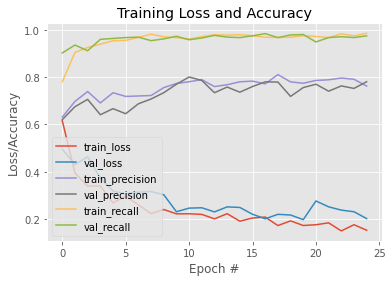

In [26]:
N = epochs
H = model_history
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["precision"], label="train_precision")
plt.plot(np.arange(0, N), H.history["val_precision"], label="val_precision")
plt.plot(np.arange(0, N), H.history["recall"], label="train_recall")
plt.plot(np.arange(0, N), H.history["val_recall"], label="val_recall")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [32]:
model.save('face_mask_cat_Xception.h5')

Inferencia

Preparamos la data para pruebas

In [33]:
new_model = tf.keras.models.load_model('face_mask_cat_Xception.h5')
#new_model.summary()

In [34]:
evaluation = new_model.evaluate(validation_dataset)

17/17 [==============================] - 7s 347ms/step - loss: 0.2026 - precision: 0.7837 - recall: 0.9814


In [35]:
img_path = '/notebooks/SIMPLE/' + validation_dataset.filenames[5]
image_loaded = load_img(img_path, target_size=target_size)
image = img_to_array(image_loaded)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
preds = new_model.predict(image)[0]
mask_labels[preds.argmax(axis=-1)]

'incorrect_mask'

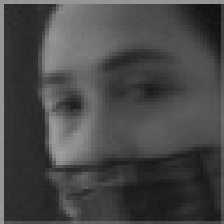

In [36]:
image_loaded